In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [11]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

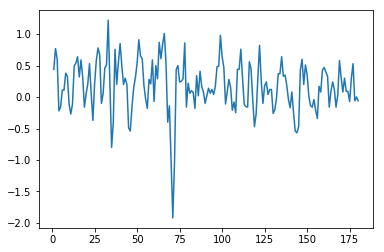

In [2]:
#squeeze=True reads it as series instead of data frame
series = pd.read_csv('./data/us_infl.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
series.plot()
plt.show()

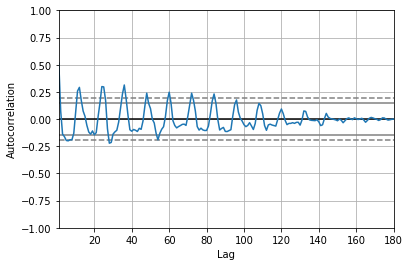

In [5]:
autocorrelation_plot(series)

# a very clear seasonal pattern exists

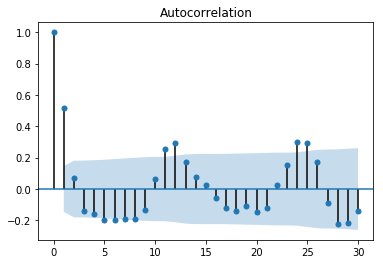

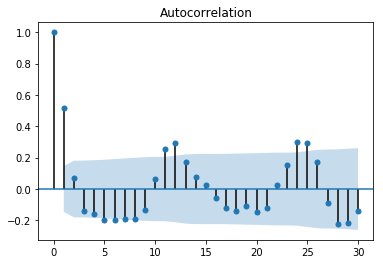

In [8]:
plot_acf(series, lags=30)

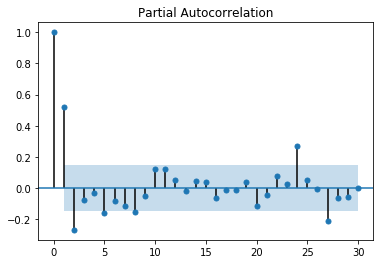

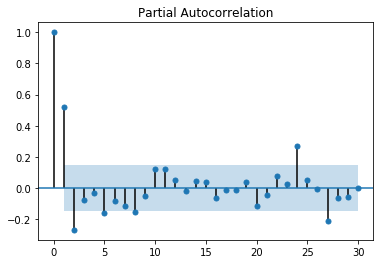

In [9]:
plot_pacf(series, lags=30)

In [10]:
def fuller_test(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
    	print('\t%s: %.3f' % (key, value))
        
fuller_test(series.values)

ADF Statistic: -8.599116
p-value: 0.000000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


In [25]:
X = series.values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]


# define model configuration
my_order = (2,0,0)
my_seasonal_order = (2,0,0, 12)
# define model
model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  135
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                 -52.748
Date:                            Mon, 13 Apr 2020   AIC                            115.496
Time:                                    20:36:24   BIC                            130.023
Sample:                                         0   HQIC                           121.400
                                            - 135                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6176      0.084      7.350      0.000       0.453       0.782
ar.L2         -0.2265      0.075   

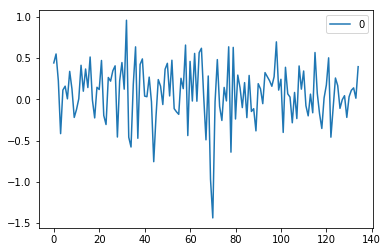

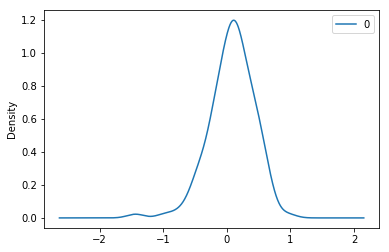

                0
count  135.000000
mean     0.077732
std      0.349590
min     -1.436759
25%     -0.113824
50%      0.111590
75%      0.290614
max      0.956942


In [26]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [28]:
predictions=model_fit.predict(start=136,end=180)

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)

Test RMSE: 0.308
Test R2: -0.141


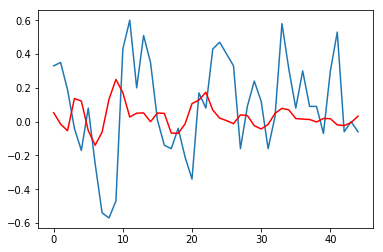

In [29]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test RMSE: 0.308
Test R2: 0.350


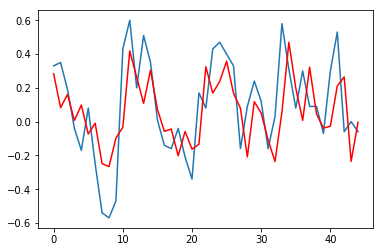

In [31]:
#### ROLLING FORECAST

X = series.values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(2,0,0), seasonal_order=(2,0,0,12))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

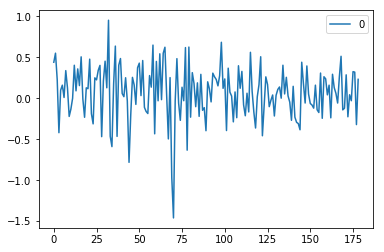

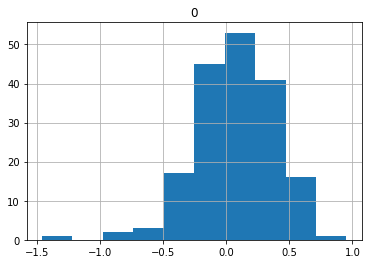

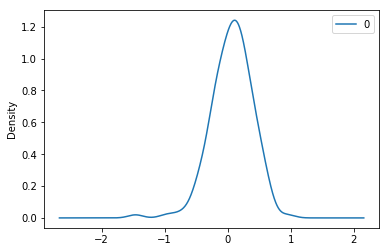

                0
count  179.000000
mean     0.066188
std      0.324963
min     -1.461050
25%     -0.126678
50%      0.082978
75%      0.270016
max      0.952903


In [34]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.hist()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

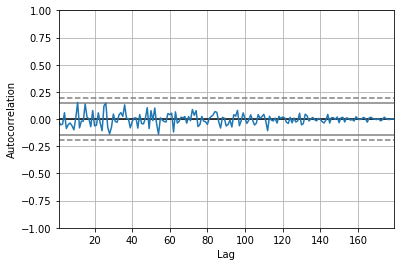

In [33]:
autocorrelation_plot(residuals)

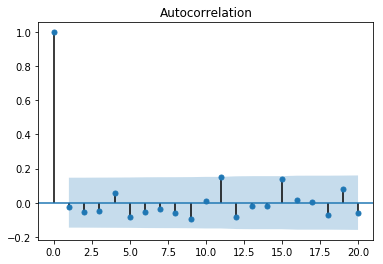

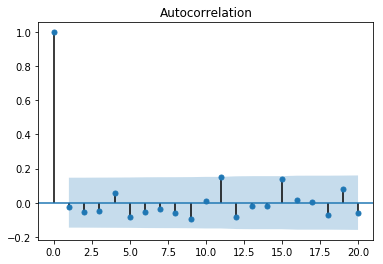

In [35]:
plot_acf(residuals,lags=20)

#this indicates that almost the entire correlation is captured and only randomness is left.